In [2]:
# Load libraries
import sys
import sys
sys.path.append("../../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date


importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    17:55:18 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    17:55:18 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    17:55:18 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


In [3]:
# Load data
def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

ds_101 = reload("A101")
ds_103 = reload("A103_fixed")
ds_104 = reload("A104")

ds_101 = ds_101.isel(time=range(20,len(ds_101.time)))
ds_103 = ds_103.isel(time=range(60,len(ds_103.time)))
ds_104 = ds_104.isel(time=range(50,len(ds_104.time)))


def reload_winter(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_winter22_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101_w = reload_winter("A101")
ds_103_w = reload_winter("A103")
ds_104_w = reload_winter("A104")

def reload_summer(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_summer_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101_s = reload_summer("A101")
ds_103_s = reload_summer("A103")
ds_104_s = reload_summer("A104")

In [3]:
ds_101.isel(attenuator_setting_pair=1).nbytes/1e9 + ds_101_w.isel(attenuator_setting_pair=1).nbytes/1e9

299.373123964

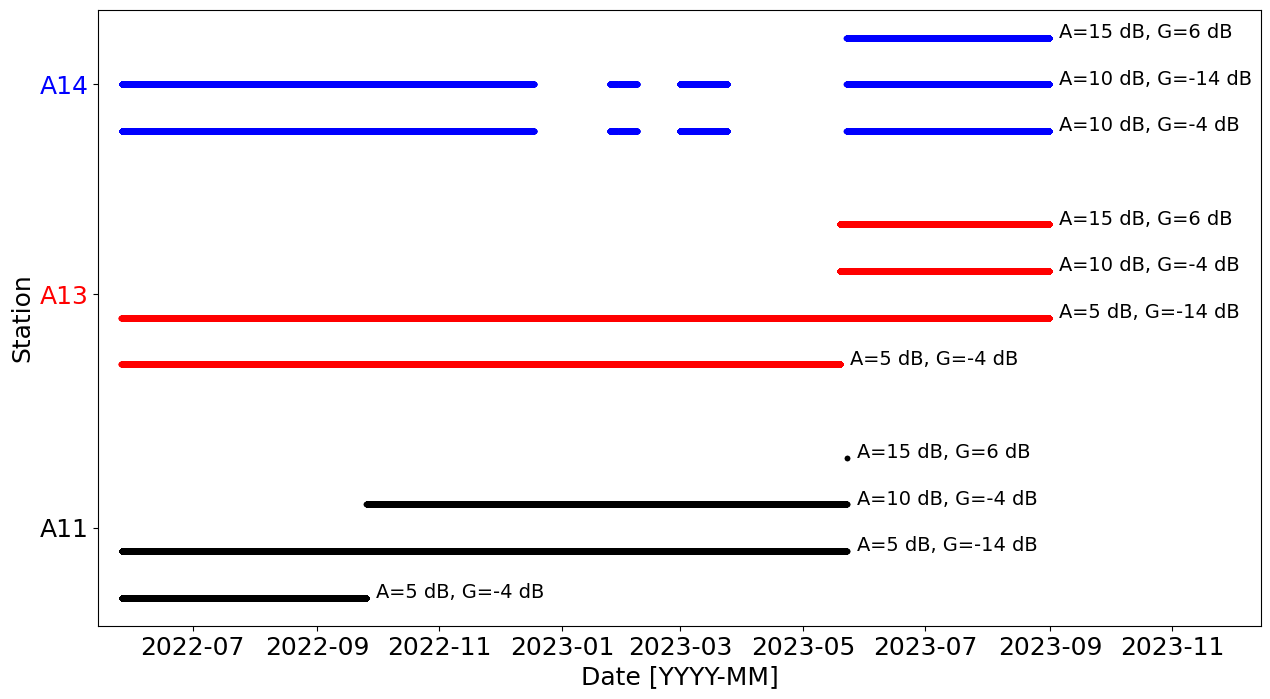

In [6]:
fig, ax = plt.subplots(figsize=(15,8))
anchors = [0,1,2]
a101 = [ds_101,ds_101_w, ds_101_s]
a103 = [ds_103,ds_103_w, ds_103_s]
a104 = [ds_104,ds_104_w, ds_104_s]
site_array = [a101,a103,a104]
site_names = ['A11','A13','A14']
station_colors = ['black','red','blue']
true_anchors = []

for i in anchors:
    station_array = site_array[i]
    setting_count = 0
    setting_pairs = []
    labels = []
    for season in station_array:
        for j in range(len(season.attenuator_setting_pair)):
            pair = (season.attenuator.values[j],season.AFGain.values[j])
            if pair not in setting_pairs:
                setting_pairs.append(pair)
                anchor_point = i + 0.2*setting_count
                setting_count += 1   
                plt.plot(season.time.values,anchor_point*np.ones(season.time.values.shape),linestyle='None',marker='.',color=station_colors[i])
                text = ax.text(season.time.values[-1]+np.timedelta64(5,'D'),anchor_point,f'A={int(pair[0])} dB, G={pair[1]} dB',fontsize=14)
                labels.append(text)
            else:
                anchor_point = i + 0.2*setting_pairs.index(pair)
                plt.plot(season.time.values,anchor_point*np.ones(season.time.values.shape),linestyle='None',marker='.',color=station_colors[i])
                labels[setting_pairs.index(pair)].set_position((season.time.values[-1]+np.timedelta64(5,'D'),anchor_point))

    true_anchors.append(i + 0.1*(setting_count-1))
ax.set_yticks(true_anchors)
ax.set_yticklabels(site_names,fontsize=14)
for ytick, color in zip(ax.get_yticklabels(), station_colors):
    ytick.set_color(color)
plt.xlim([np.datetime64('2022-05-15'), np.datetime64('2023-12-15')])
plt.xlabel('Date [YYYY-MM]',fontsize=18)
plt.ylabel('Station',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)


In [5]:
#ds_103_s.isel(attenuator_setting_pair=1).AFGain.values

In [6]:
#ds_103_full = xr.concat([ds_103.chirp.isel(attenuator_setting_pair=1),ds_103_w.chirp.isel(attenuator_setting_pair=1),ds_103_s.chirp.isel(attenuator_setting_pair=1)],'time')

In [7]:
#ds_103_full

In [8]:
# define function
def custom_stacked_profile_series(chirps,pad=2,F0=2e8,F1=4e8):
    StartFreq = 2e8
    StopFreq = 4e8
    B = StopFreq - StartFreq
    CentreFreq = B/2
    K = 2e8 
    dt = 1/40000
    c0 = 3e8 # speed of light in vaccuum
    ER_ICE = 3.18
    T0 = (F0-StartFreq)/K
    T1 = (F1-StartFreq)/K

    chirps = chirps.isel(chirp_time=range(math.ceil(T0/dt),math.floor(T1/dt)+1)).mean(dim='chirp_num')
    window = np.blackman(len(chirps.chirp_time))
    win_chirps = chirps*window
    Nt = len(chirps.chirp_time)
    Nfft = math.floor(Nt*pad)
    bin2m = c0/(2.*(T1-T0)*pad*math.sqrt(ER_ICE)*K)
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    padchirp = np.zeros((len(chirps.time),Nfft))
    padchirp[:,0:math.floor(Nt/2)] = win_chirps.data[:,math.floor(Nt/2):-1]
    padchirp[:,-math.floor(Nt/2):] = win_chirps.data[:,0:math.floor(Nt/2)]
    p = np.fft.fft(padchirp,axis=1)/Nfft * math.sqrt(2*pad)
    profile = p[:,0:math.floor(Nfft/2)-1]
    m = np.asarray([i for i in range(profile.shape[1])])/pad
    phiref = 2*math.pi*CentreFreq*m/B - m * m * 2*math.pi * K/2/B**2
    profile_ref = profile * np.exp(phiref[np.newaxis,:]*(-1j))
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    n = np.argmin(profile_range<=1400)
    Range = profile_range[:n]
    Profile = profile_ref[:,:n]
    da = xr.DataArray(Profile,
                  dims=['time','profile_range'],
                  coords={'profile_range': Range,
                         'time': chirps.time.data})
    return da

In [9]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41963")
client

<Client: 'tcp://127.0.0.1:41963' processes=4 threads=16, memory=125.81 GiB>

In [10]:
da_101_stacked  = custom_stacked_profile_series(ds_101.chirp.isel(attenuator_setting_pair=1),2,3e8,4e8)


In [11]:

da_101_stacked['doy_decimal'] = da_101_stacked.time.dt.dayofyear + (da_101_stacked.time.dt.hour / 24) + (da_101_stacked.time.dt.minute / 1440) + (da_101_stacked.time.dt.second / 86400)


In [12]:
da_101_stacked

<xarray.DataArray (time: 11703, profile_range: 3329)>
array([[ 1.08482968e-02+0.00000000e+00j, -5.77989234e-06-9.55773262e-03j,
        -6.45420474e-03+1.45865198e-05j, ...,
         1.89682734e-06+1.77175996e-06j,  1.18633557e-06-2.06368649e-06j,
        -1.33655487e-06-3.65275439e-07j],
       [ 1.08468895e-02+0.00000000e+00j, -5.91414110e-06-9.55679587e-03j,
        -6.45427863e-03+1.43538348e-05j, ...,
        -2.34543537e-06+1.95904104e-06j,  2.17299736e-07+2.51953295e-06j,
         3.20299932e-06+1.25074639e-06j],
       [ 1.08443403e-02+0.00000000e+00j, -5.72733122e-06-9.55447117e-03j,
        -6.45241417e-03+1.37297730e-05j, ...,
        -1.25790232e-06+2.37452862e-06j,  1.02476601e-06+1.60955150e-07j,
        -2.91737157e-07-1.90302161e-07j],
       ...,
       [ 1.10404251e-02+0.00000000e+00j,  1.70785245e-06-9.72449912e-03j,
        -6.56303291e-03+6.78826785e-06j, ...,
        -2.17037142e-08+4.74168728e-06j,  4.26039455e-06-1.30172305e-06j,
        -2.58972185e-06-2.55370307e-06j],
       [ 1.10387110e-02+0.00000000e+00j,  1.66319670e-06-9.72302936e-03j,
        -6.56214313e-03+6.79265374e-06j, ...,
         1.70363597e-06+4.16310353e-06j,  3.66262333e-06-2.65704976e-06j,
        -3.47405111e-06-1.95692416e-06j],
       [ 1.10399303e-02+0.00000000e+00j,  1.66319706e-06-9.72416745e-03j,
        -6.56307335e-03+6.68681470e-06j, ...,
         3.21569617e-07+4.44798695e-06j,  4.54971449e-06-1.87061721e-07j,
         2.05724810e-08-3.14394533e-06j]])
Coordinates:
  * profile_range  (profile_range) float64 0.0 0.4206 ... 1.399e+03 1.4e+03
  * time           (time) datetime64[ns] 2022-05-26T17:06:29 ... 2022-09-25T1...
    doy_decimal    (time) float64 146.7 146.7 146.7 146.7 ... 268.6 268.6 268.6

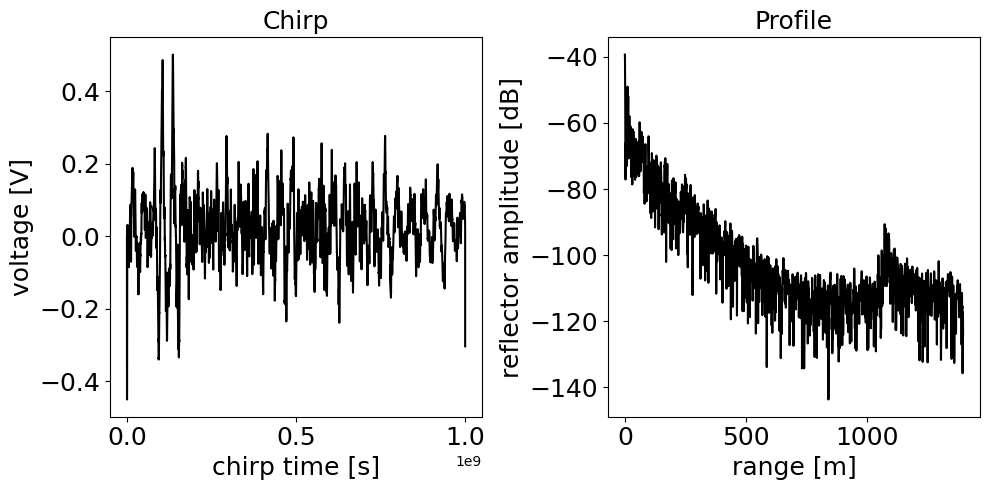

In [13]:
fig, axs = plt.subplots(ncols = 2,figsize=(10,5),layout='tight')
ds_101.chirp.isel(attenuator_setting_pair=1,time=0).mean(dim='chirp_num').plot(ax=axs[0],color='k')
axs[0].set_ylabel('voltage [V]',fontsize=18)
axs[0].set_xlabel('chirp time [s]',fontsize=18)
axs[0].set_title('Chirp',fontsize=18)
axs[0].tick_params(axis='both', which='major', labelsize=18)

xa.dB(da_101_stacked.isel(time=100)).plot(ax=axs[1],color='black')
axs[1].set_ylabel('reflector amplitude [dB]',fontsize=18)
axs[1].set_xlabel('range [m]',fontsize=18)

axs[1].set_title('Profile',fontsize=18)

axs[1].tick_params(axis='both', which='major', labelsize=18)
#plt.savefig('output_plot.png', transparent=True)


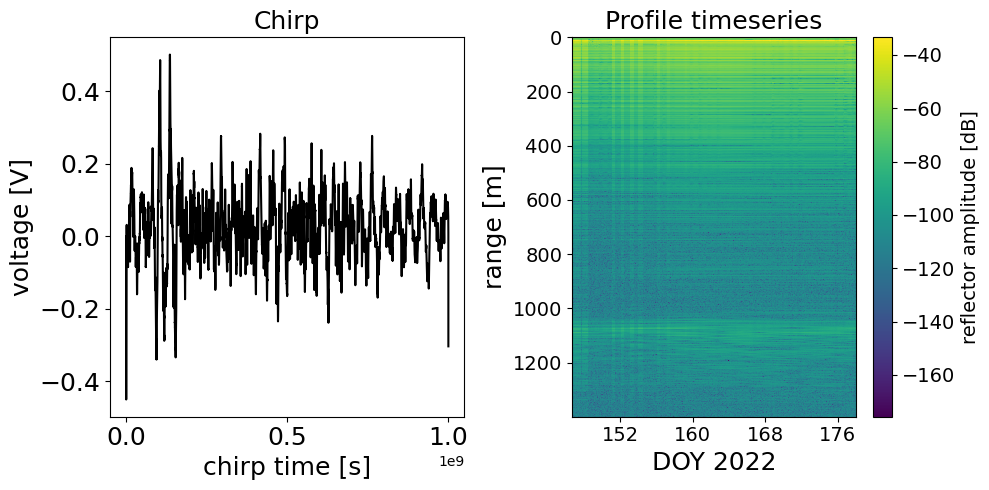

In [14]:
fig, axs = plt.subplots(ncols = 2,figsize=(10,5),layout='tight')
ds_101.chirp.isel(attenuator_setting_pair=1,time=0).mean(dim='chirp_num').plot(ax=axs[0],color='k')
axs[0].set_ylabel('voltage [V]',fontsize=18)
axs[0].set_xlabel('chirp time [s]',fontsize=18)
axs[0].set_title('Chirp',fontsize=18)
axs[0].tick_params(axis='both', which='major', labelsize=18)

fg = xa.dB(da_101_stacked.isel(time=range(0,3000))).plot(ax=axs[1],x='doy_decimal')
#axs[1].set_ylabel('reflector amplitude [dB]',fontsize=18)
axs[1].invert_yaxis()
axs[1].set_ylabel('range [m]',fontsize=18)
#axs[1].set_xlabel('depth [m]',fontsize=18)
axs[1].set_xlabel('DOY 2022',fontsize=18)
fg.colorbar.ax.tick_params(labelsize=14)
fg.colorbar.set_label(label='reflector amplitude [dB]', size=14)

axs[1].set_title('Profile timeseries',fontsize=18)
space = 8
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(space)) 
axs[1].tick_params(axis='both', which='major', labelsize=14)


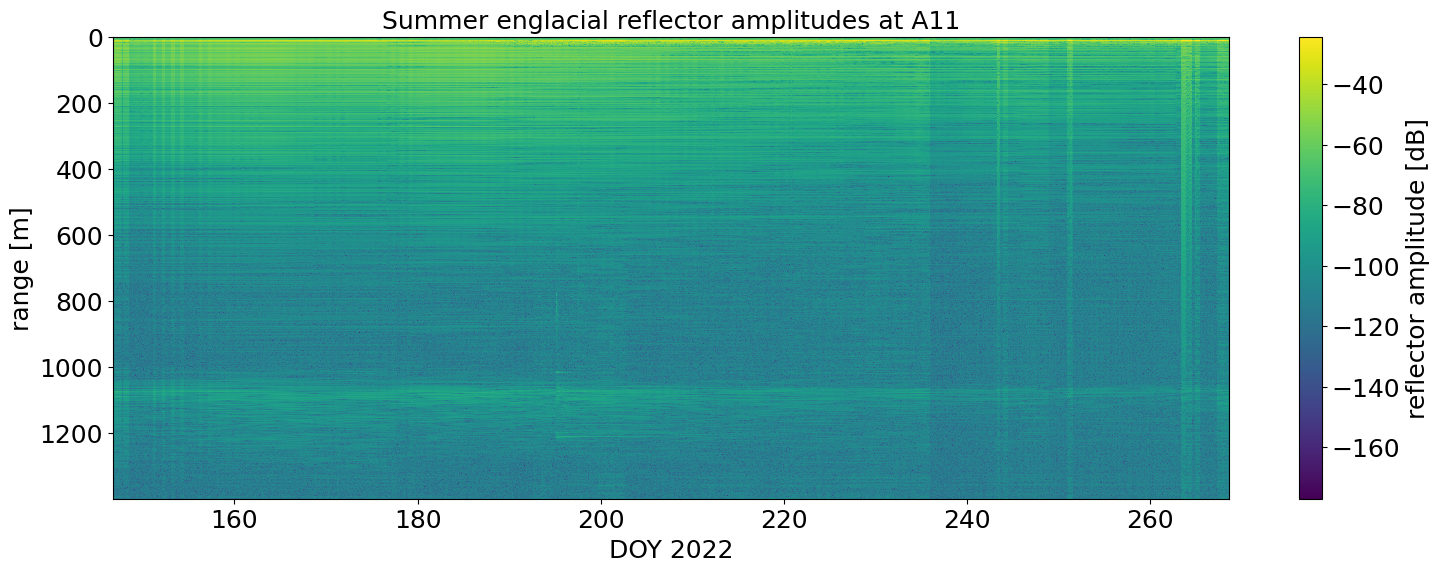

In [15]:
fig, ax = plt.subplots(figsize=(18,6))
fg = xa.dB(da_101_stacked).plot(ax=ax,x='doy_decimal')
fg.colorbar.ax.tick_params(labelsize=18)
fg.colorbar.set_label(label='reflector amplitude [dB]', size=18)
ax.invert_yaxis()
ax.set_title("Summer englacial reflector amplitudes at A11",fontsize=18)
plt.xlabel('DOY 2022',fontsize=18)
plt.ylabel('range [m]',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)


In [16]:
da_101_stacked.time


<xarray.DataArray 'time' (time: 11703)>
array(['2022-05-26T17:06:29.000000000', '2022-05-26T17:21:30.000000000',
       '2022-05-26T17:36:30.000000000', ..., '2022-09-25T13:50:49.000000000',
       '2022-09-25T14:05:43.000000000', '2022-09-25T14:20:39.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2022-05-26T17:06:29 ... 2022-09-25T14:...
    doy_decimal  (time) float64 146.7 146.7 146.7 146.7 ... 268.6 268.6 268.6

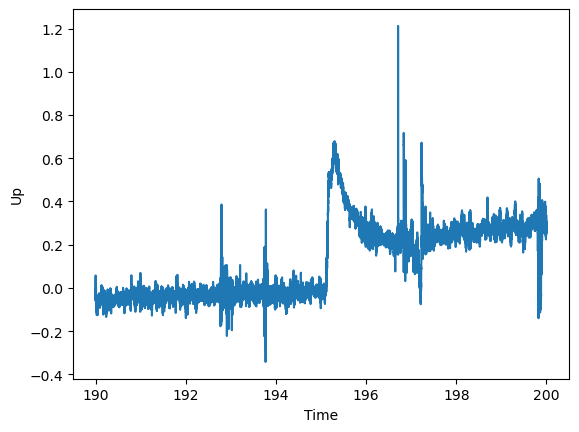

In [17]:
data = pd.read_csv('sq11.csv')
#data['datetime']=  pd.to_datetime(
#                      data['Time'], unit='D', origin=pd.Timestamp('2021-12-31')
#                      )

data = data.set_index('Time')
data = data.to_xarray()
data.Up.plot(x='Time')

Text(0, 0.5, 'range [m]')

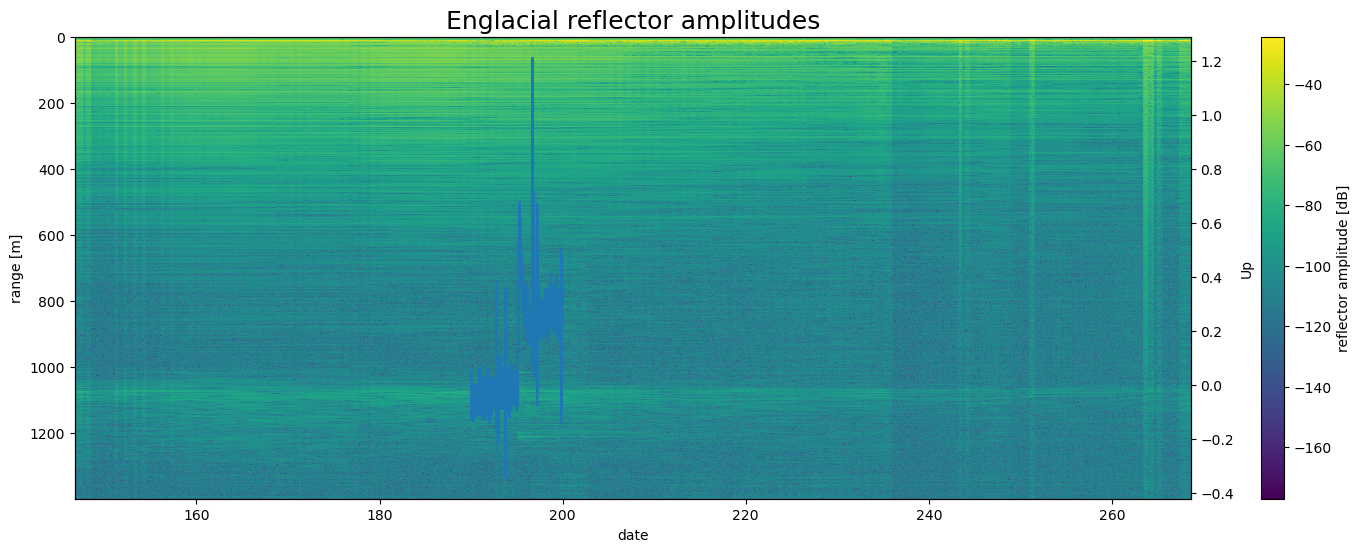

In [18]:
fig, ax = plt.subplots(figsize=(18,6))
xa.dB(da_101_stacked).plot(ax=ax,x='doy_decimal',cbar_kwargs={'label':'reflector amplitude [dB]'})
ax.invert_yaxis()
ax.set_title("Englacial reflector amplitudes",fontsize=18)
ax2 = ax.twinx()
data.Up.plot(ax=ax2,x='Time')
ax.set_xlabel('date')
ax.set_ylabel('range [m]')
      

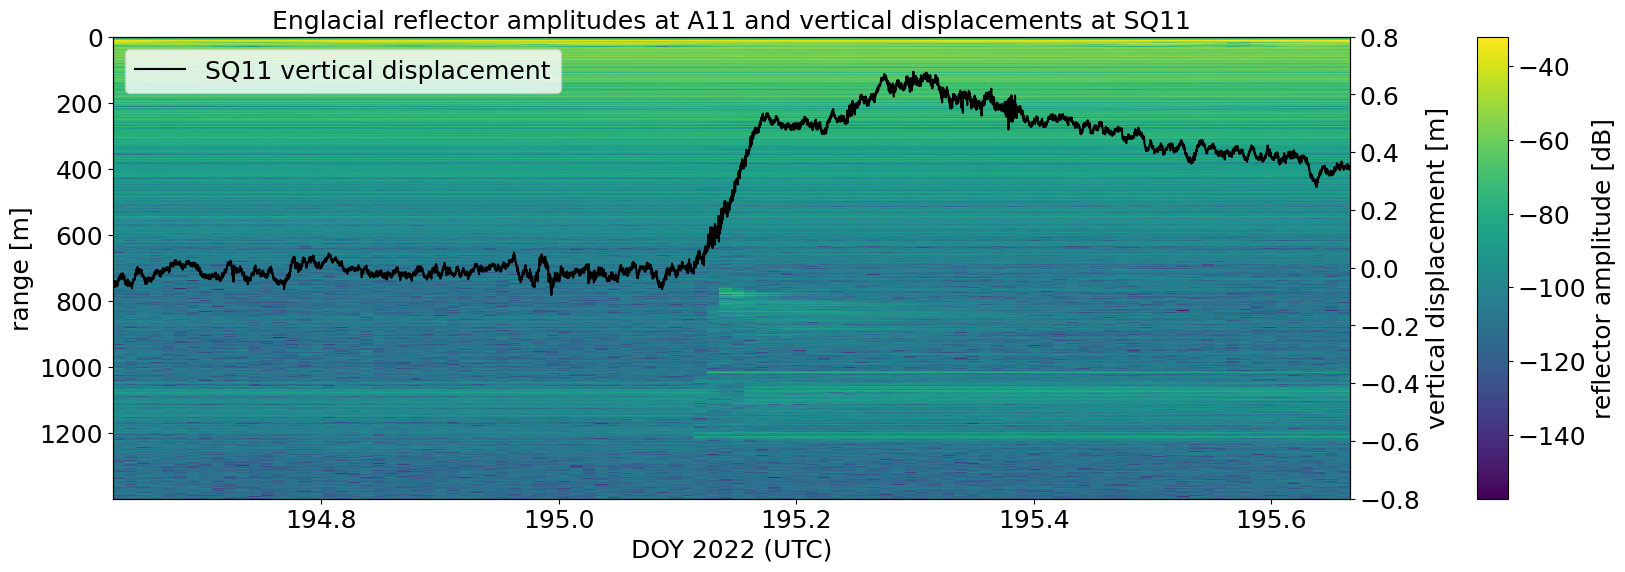

In [19]:
fig, [ax1, cax] = plt.subplots(1,2, gridspec_kw=dict(width_ratios=[40,1]),figsize=(18,6))

fg=xa.dB(da_101_stacked.isel(time=range(4600,4700))).plot(ax=ax1,x='doy_decimal',add_colorbar=False)
cbar = plt.colorbar(fg, cax=cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label='reflector amplitude [dB]', size=18)
ax1.invert_yaxis()
ax2 = ax1.twinx()
ax2.set_ylim([-0.8,0.8])
data.Up.plot(ax=ax2,x='Time',color='k',label='SQ11 vertical displacement')
ax2.set_ylabel('vertical displacement [m]',fontsize=18)

ax1.set_title("Englacial reflector amplitudes at A11 and vertical displacements at SQ11",fontsize=18)
ax1.set_xlabel('DOY 2022 (UTC)',fontsize=18)
ax1.set_ylabel('range [m]',fontsize=18)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)

ax2.legend(fontsize=18)

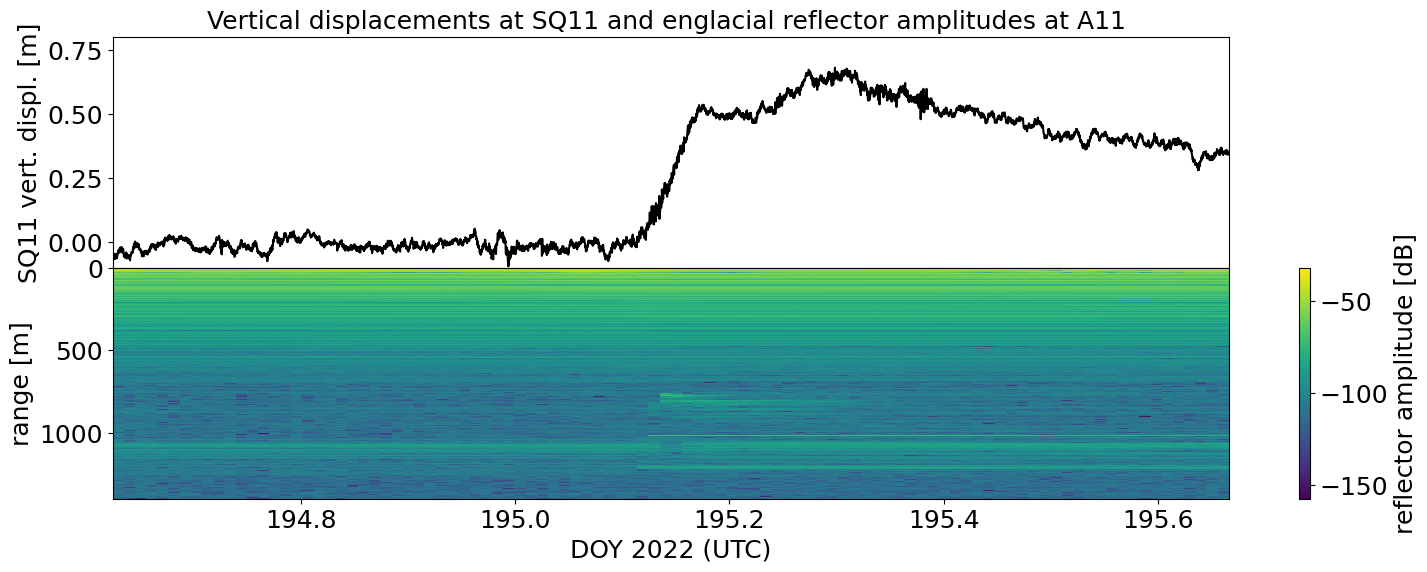

In [20]:
fig, [ax1, ax2] = plt.subplots(nrows=2, sharex=True,gridspec_kw=dict(height_ratios=[1,1]),figsize=(18,6))

fg=xa.dB(da_101_stacked.isel(time=range(4600,4700))).plot(ax=ax2,x='doy_decimal')
fg.colorbar.ax.tick_params(labelsize=18)
fg.colorbar.set_label(label='reflector amplitude [dB]', size=18)
ax2.invert_yaxis()
ax2.set_title("")


data.Up.plot(ax=ax1,x='Time',color='k',label='SQ11 vertical displacement')
ax1.set_ylabel('SQ11 vert. displ. [m]',fontsize=18)
ax1.set_xlabel('')
ax1.set_ylim([-0.1,0.8])
#ax1.yaxis.set_label_position("right")

ax1.set_title("Vertical displacements at SQ11 and englacial reflector amplitudes at A11 ",fontsize=18)
#ax1.yaxis.tick_right()
ax2.set_xlabel('DOY 2022 (UTC)',fontsize=18)
ax2.set_ylabel('range [m]',fontsize=18)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)
plt.subplots_adjust(wspace=0, hspace=0)

pos = ax2.get_position()
pos2 = ax1.get_position()
ax1.set_position([pos.x0,pos2.y0,pos.width,pos2.height])
#ax2.legend(fontsize=18)
plt.savefig('output_plot.png', transparent=True)


In [21]:
(da_101_stacked.isel(time=range(4600,4700)).time[-1] - da_101_stacked.isel(time=range(4600,4700)).time[0])/1e9/60/60

<xarray.DataArray 'time' ()>
array(24, dtype='timedelta64[ns]')

## plotting winter strain

In [22]:
ds_101_w.time.isel(time=range(9348,18000))

<xarray.DataArray 'time' (time: 8652)>
array(['2023-01-01T00:12:02.000000000', '2023-01-01T00:27:06.000000000',
       '2023-01-01T00:42:06.000000000', ..., '2023-04-01T02:10:10.000000000',
       '2023-04-01T02:25:12.000000000', '2023-04-01T02:40:17.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    burst_number  (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    filename      (time) <U89 dask.array<chunksize=(1,), meta=np.ndarray>
  * time          (time) datetime64[ns] 2023-01-01T00:12:02 ... 2023-04-01T02...
Attributes:
    long_name:  time of burst

In [23]:
a11_winter_23 = ds_101_w.profile_stacked.isel(attenuator_setting_pair=1,time=range(9348,18000)).compute()
a11_winter_23['doy_decimal'] = a11_winter_23.time.dt.dayofyear + (a11_winter_23.time.dt.hour / 24) + (a11_winter_23.time.dt.minute / 1440) + (a11_winter_23.time.dt.second / 86400)


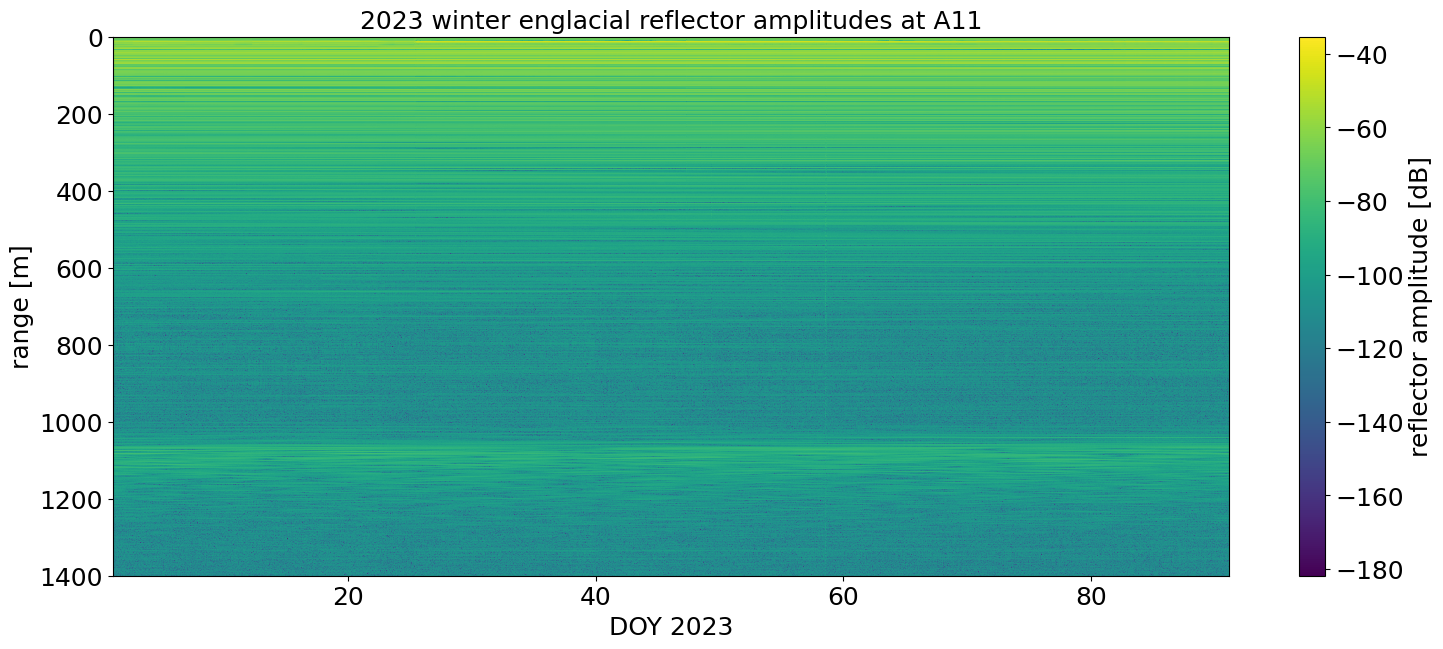

In [24]:
fig, ax = plt.subplots(figsize=(18,7))
fg = xa.dB(a11_winter_23).plot(ax=ax,x='doy_decimal')
fg.colorbar.ax.tick_params(labelsize=18)
fg.colorbar.set_label(label='reflector amplitude [dB]', size=18)
ax.invert_yaxis()
ax.set_title("2023 winter englacial reflector amplitudes at A11",fontsize=18)
plt.xlabel('DOY 2023',fontsize=18)
plt.ylabel('range [m]',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)


In [25]:
b1= a11_winter_23.isel(time=range(0,len(a11_winter_23)-1))
b2 = a11_winter_23.isel(time=range(1,len(a11_winter_23)))
ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,80,80,None,0,0.95)
ds_full['doy_decimal'] = ds_full.time.dt.dayofyear + (ds_full.time.dt.hour / 24) + (ds_full.time.dt.minute / 1440) + (ds_full.time.dt.second / 86400)
ds_full=ds_full.assign(coherence=(['time','profile_range'],co_full))

INFO     15:28:41 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [904. 900. 900. ... 871. 902. 905.]s


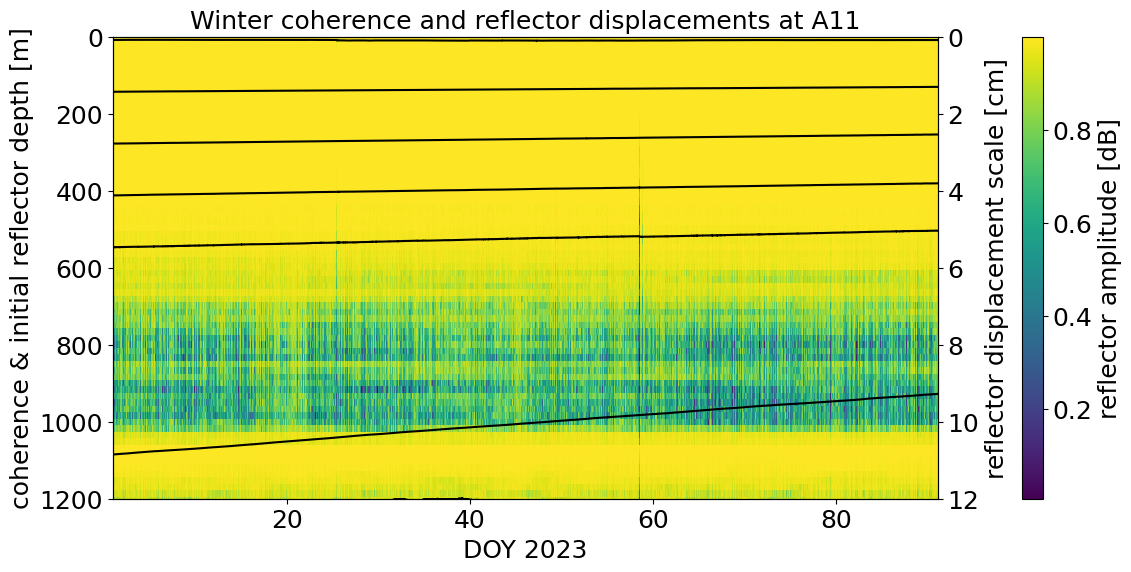

In [26]:
fig, [ax,cax] = plt.subplots(1,2, gridspec_kw=dict(width_ratios=[40,1]),figsize=(12,6))
im = ax.pcolormesh(ds_full.doy_decimal,ds_full.profile_range,abs(co_full).transpose())
cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label='reflector amplitude [dB]', size=18)

ax.set_ylim([0,1200])
ax1= ax.twinx()
ax1.set_ylim([0,12])

ax.invert_yaxis()
ax1.invert_yaxis()

count = 0
for i in np.arange(0,len(ds_full.profile_range),len(ds_full.profile_range)//10):
    if count < 5 or count > 7:
        to_plot = ds_full.range_diff.cumsum(dim='time').isel(profile_range = i) + ds_full.profile_range.isel(profile_range = i)/100
        to_plot['doy_decimal'] = to_plot.time.dt.dayofyear + (to_plot.time.dt.hour / 24) + (to_plot.time.dt.minute / 1440) + (to_plot.time.dt.second / 86400)
        to_plot.plot(ax=ax1,x='doy_decimal',color='k')
    count += 1
ax.set_title('Winter coherence and reflector displacements at A11',fontsize=18)
ax1.set_title('')
ax.set_ylabel('coherence & initial reflector depth [m]',fontsize=18)
ax1.set_ylabel('reflector displacement scale [cm]',fontsize=18)
ax.set_xlabel('DOY 2023',fontsize=18)

ax.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(axis='both', which='major', labelsize=18)


In [27]:
def convert_to_seconds(s):
    seconds_per_unit = {"S": 1, "T": 60, "H": 3600, "D": 86400, "W": 604800}
    return int(s[:-1]) * seconds_per_unit[s[-1]]

def sum_error(errs):
    return np.sqrt(np.sum(errs**2))

def error_prop(data):
    return xr.apply_ufunc(sum_error, data, input_core_dims=[["time"]], vectorize = True)

Text(0.5, 0.01, 'vertical velocity [m y$^{-1}$]')

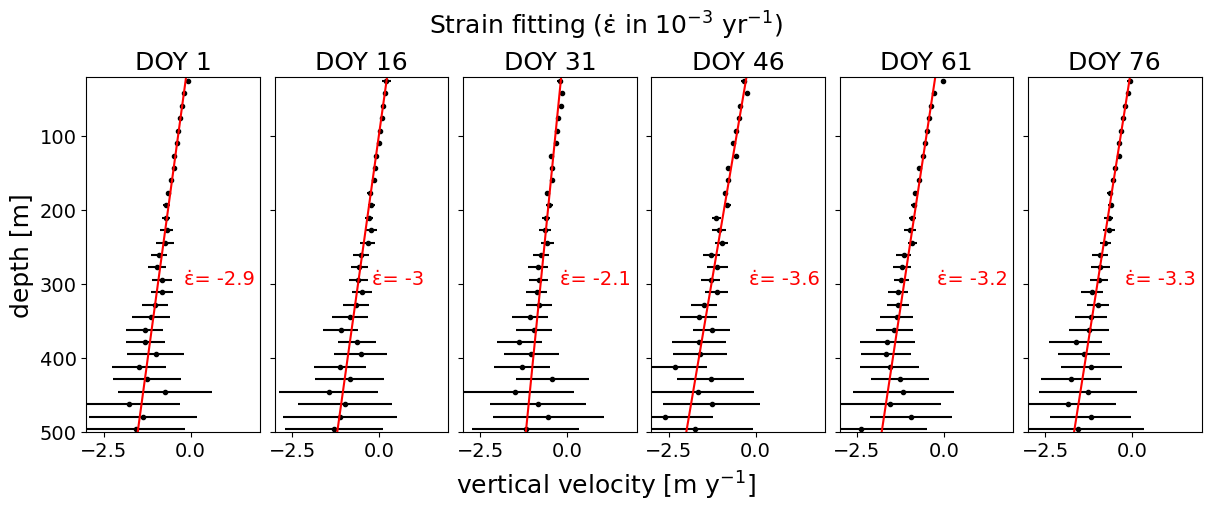

In [28]:
fig1, axs_1 = plt.subplots(ncols=6,figsize=(12,5),sharey=True,layout='constrained')
fig1.suptitle('Strain fitting (\u03B5\u0307 in 10$^{-3}$ yr$^{-1}$)',fontsize=18)
# Plotting displacement for individual layers 
j = '1D'
ds_new = ds_full.where(abs(ds_full.coherence) > 0.95)
disp_stack = ds_new.range_diff.where(ds_new.profile_range >=20).resample(time=j).sum(dim='time')/convert_to_seconds(j)*31536000
disp_stack['doy_decimal'] = disp_stack.time.dt.dayofyear + (disp_stack.time.dt.hour / 24) + (disp_stack.time.dt.minute / 1440) + (disp_stack.time.dt.second / 86400)

err_stack = ds_new.err.where(ds_new.profile_range >=20).resample(time=j).apply(error_prop)/convert_to_seconds(j)*31536000
strain_polyfit = disp_stack.where(disp_stack.profile_range <=500).polyfit('profile_range',1)
plt_count = 0
for i in np.arange(0,len(disp_stack.time),len(disp_stack.time)//6):
    axs_1[plt_count].errorbar(disp_stack.isel(time = i) ,disp_stack.profile_range,yerr=None,xerr=err_stack.isel(time = i),linestyle='',marker='.',color='k',zorder=1)
    fit = strain_polyfit.polyfit_coefficients.sel(degree=1).isel(time=i).values*np.linspace(20,500)+strain_polyfit.polyfit_coefficients.sel(degree=0).isel(time=i).values

    axs_1[plt_count].plot(fit,np.linspace(20,500),color='r',zorder=2)
    unit = ''#'x10$^{-3}$ yr$^{-1}$'
    axs_1[plt_count].text(-0.2,300, f"\u03B5\u0307= {strain_polyfit.polyfit_coefficients.sel(degree=1).isel(time=i).values*1000:.2g}"+unit,color = 'r',fontsize=14)
    axs_1[plt_count].set_title(f'DOY {int(disp_stack.doy_decimal.isel(time = i).values)}',fontsize=18)
    axs_1[plt_count].set_xlim([-3,2])
    axs_1[plt_count].set_ylim([20,500])
    axs_1[plt_count].tick_params(axis='both', which='major', labelsize=14)
    plt_count += 1
    if plt_count == 6:
        break

axs_1[0].invert_yaxis()

axs_1[0].set_ylabel('depth [m]',fontsize=18)
fig1.supxlabel('vertical velocity [m y$^{-1}$]',fontsize=18)

In [69]:
strain_polyfit

<xarray.Dataset>
Dimensions:               (time: 239, degree: 2)
Coordinates:
  * time                  (time) datetime64[ns] 2022-09-26 ... 2023-05-22
  * degree                (degree) int64 1 0
Data variables:
    polyfit_coefficients  (degree, time) float64 -0.006542 0.009508 ... -0.09106

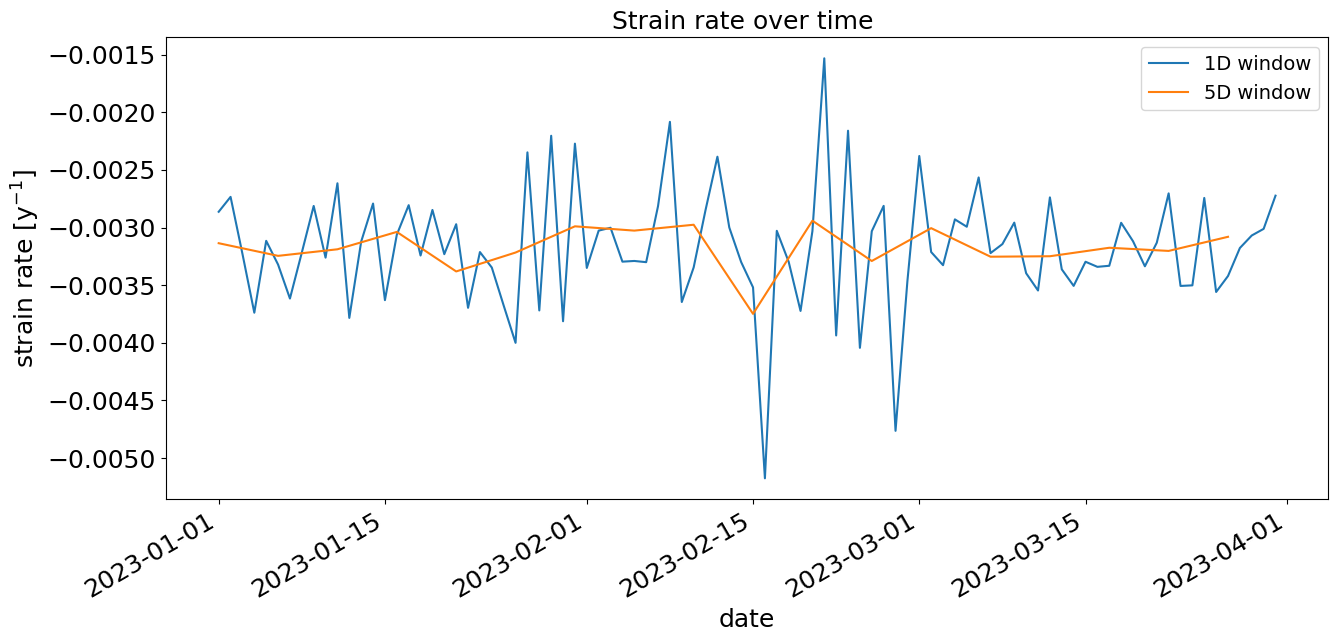

In [171]:
fig, ax = plt.subplots(figsize=(15,6))

for i in ['1D','5D']:
    disp_stack = ds_full.range_diff.resample(time=i).sum(dim='time')/convert_to_seconds(i)*31536000
    
    err_stack = ds_full.err.resample(time=i).apply(error_prop)/convert_to_seconds(i)*31536000
    strain_polyfit = disp_stack.where(disp_stack.profile_range <=500).polyfit('profile_range',1)
    strain_polyfit.polyfit_coefficients.sel(degree=1)[:-1].plot(ax=ax,label=f'{i} window')
    
ax.set_ylabel('strain rate [y$^{-1}$]',fontsize=18)
ax.set_xlabel('date',fontsize=18)

ax.set_title(f'Strain rate over time ',fontsize=18)
plt.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=18)


In [172]:
# stagger the bursts
da_crop = da_101_stacked.isel(time=range(4600,4700))
b1= da_crop.isel(time=range(0,len(da_crop)-1))
b2 = da_crop.isel(time=range(1,len(da_crop)))

In [173]:
ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,80,80,None,0,0.95)


INFO     02:31:35 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [891. 899. 900. 900. 902. 900. 900. 900. 901. 916. 901. 882. 901. 899.
 900. 900. 900. 901. 900. 922. 907. 869. 899. 901. 901. 899. 901. 900.
 899. 901. 900. 900. 900. 900. 900. 902. 899. 899. 901. 929. 868. 900.
 900. 901. 902. 899. 900. 900. 930. 870. 900. 900. 899. 901. 900. 900.
 900. 907. 895. 901. 902. 897. 904. 900. 903. 901. 901. 919. 869. 900.
 901. 899. 901. 899. 901. 903. 927. 869. 900. 900. 901. 900. 902. 928.
 870. 899. 900. 900. 931. 869. 899. 900. 903. 905. 893. 901. 900. 900.
 900.]s


Text(0, 0.5, 'depth [m], displacement [cm]')

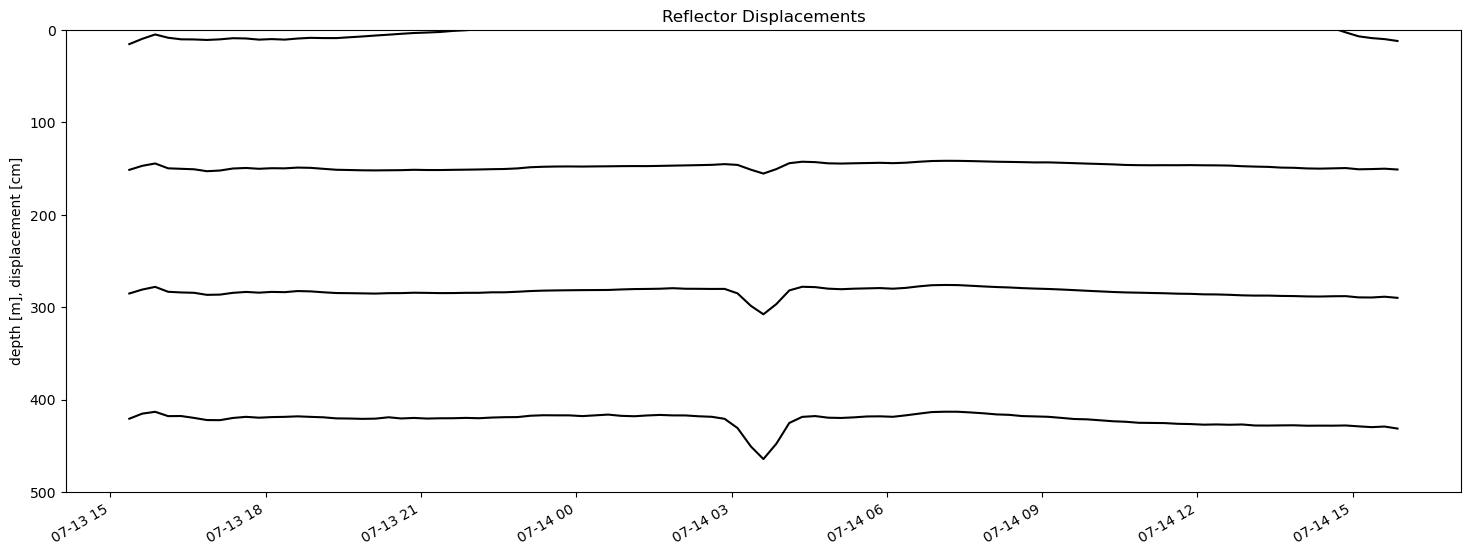

In [176]:
fig, ax = plt.subplots(figsize=(18,6))

for i in np.arange(0,len(ds_full.profile_range),len(ds_full.profile_range)//10):
    (1000*ds_full.range_diff.cumsum(dim='time').isel(profile_range = i) + ds_full.profile_range.isel(profile_range = i)).plot(color='k')
ax.set_ylim([0,500])
ax.invert_yaxis()
ax.set_title('Reflector Displacements')
ax.set_xlabel('')
ax.set_ylabel('depth [m], displacement [cm]')

In [177]:
vd_sum = '1H'
disp_stack = ds_full.range_diff.resample(time=vd_sum).sum(dim='time')/convert_to_seconds(vd_sum)*31536000
err_stack = ds_full.err.resample(time=vd_sum).apply(error_prop)/convert_to_seconds(vd_sum)*31536000
strain_polyfit = strain_polyfit = disp_stack.where(disp_stack.profile_range <=500).polyfit('profile_range',1)


INFO     02:37:09 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [889. 900. 911. 895. 896. 901. 930. 878. 900. 894. 906. 900. 900. 900.
 900. 900. 901. 902. 900. 920. 876. 900. 900. 888. 912. 900. 902. 898.
 900. 901. 899. 923. 865. 912. 888. 900. 900. 913. 887. 912. 901. 900.
 900. 899. 889. 901. 899. 901. 899. 900. 900. 900. 901. 900. 899. 901.
 901. 899. 900. 900. 900. 900. 900. 900. 900. 906. 894. 900. 900. 900.
 899. 901. 900. 900. 899. 900. 901. 900. 900. 902. 900. 900. 900. 909.
 905. 895. 923. 877. 900. 888. 900. 903. 899. 901. 905. 928. 866. 899.
 901. 900. 900. 900. 901. 899. 900. 900. 899. 900. 900. 901. 900. 900.
 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 934.
 865. 899. 902. 899. 900. 902. 898. 901. 900. 899. 900. 901. 900. 934.
 865. 901. 900. 899. 900. 900. 900. 900. 901. 899. 901. 900. 901. 911.
 888. 900. 901. 900. 899. 916. 885. 933. 865. 900. 899. 902. 899. 901.
 901. 899. 899. 901. 900. 899. 900. 900. 935. 867. 8

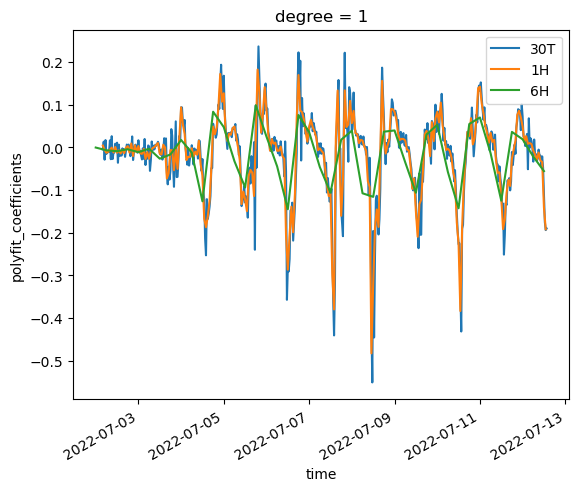

In [178]:
# Calculate weekly strain rate before and after
# 10 days before
before = da_101_stacked.isel(time=range(3500,4500))
b1 = before.isel(time=range(0,len(before)-1))
b2 = before.isel(time=range(1,len(before)))
ds_before, co_before, phi_before = xa.generate_range_diff(b1,b2,80,80,None,0,0.95)
for vd_sum in ['30T','1H','6H']:

    disp_stack = ds_before.range_diff.resample(time=vd_sum).sum(dim='time')/convert_to_seconds(vd_sum)*31536000
    err_stack = ds_before.err.resample(time=vd_sum).apply(error_prop)/convert_to_seconds(vd_sum)*31536000
    strain_polyfit = disp_stack.where(disp_stack.profile_range <=500).polyfit('profile_range',1)
    strain_polyfit.polyfit_coefficients.sel(degree=1).plot(label=vd_sum)
plt.legend()

INFO     02:37:12 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 905.
 900. 895. 934. 865. 901. 899. 901. 901. 900. 900. 900. 901. 899. 901.
 933. 865. 900. 901. 899. 901. 901. 900. 901. 898. 900. 901. 899. 934.
 865. 900. 900. 901. 900. 899. 900. 900. 901. 934. 865. 900. 901. 900.
 899. 900. 900. 900. 900. 900. 901. 934. 865. 900. 901. 900. 900. 918.
 882. 934. 864. 901. 899. 901. 900. 899. 902. 900. 900. 899. 901. 900.
 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 901. 901. 898.
 900. 904. 900. 930. 866. 900. 900. 900. 900. 899. 901. 914. 894. 926.
 865. 900. 900. 900. 902. 900. 899. 900. 900. 900. 901. 933. 866. 900.
 900. 900. 899. 902. 900. 900. 899. 901. 900. 901. 901. 931. 865. 901.
 900. 901. 899. 901. 899. 900. 902. 898. 901. 900. 911. 890. 898. 901.
 899. 934. 865. 901. 900. 901. 900. 901. 900. 940. 857. 902. 899. 901.
 900. 900. 900. 909. 891. 933. 866. 900. 900. 904. 8

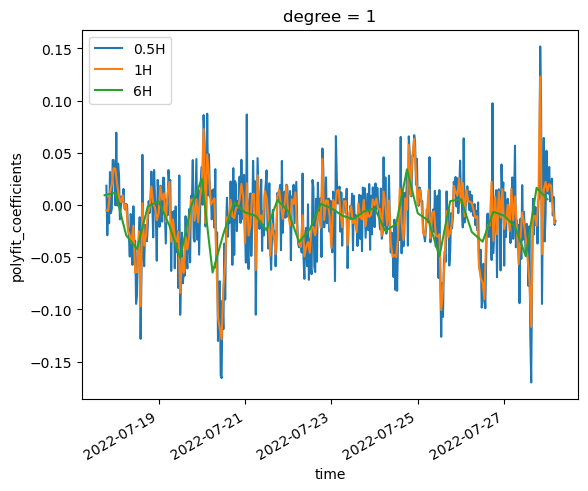

In [179]:
# 10 days after
before = da_101_stacked.isel(time=range(5000,6000))
b1 = before.isel(time=range(0,len(before)-1))
b2 = before.isel(time=range(1,len(before)))
ds_before, co_before, phi_before = xa.generate_range_diff(b1,b2,80,80,None,0,0.95)
for vd_sum in ['30T','1H','6H']:

    disp_stack = ds_before.range_diff.resample(time=vd_sum).sum(dim='time')/convert_to_seconds(vd_sum)*31536000
    err_stack = ds_before.err.resample(time=vd_sum).apply(error_prop)/convert_to_seconds(vd_sum)*31536000
    strain_polyfit = disp_stack.where(disp_stack.profile_range <=500).polyfit('profile_range',1)
    strain_polyfit.polyfit_coefficients.sel(degree=1).plot(label=vd_sum.replace('30T','0.5H'))
plt.legend()

INFO     03:11:00 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [891. 899. 900. 900. 902. 900. 900. 900. 901. 916. 901. 882. 901. 899.
 900. 900. 900. 901. 900. 922. 907. 869. 899. 901. 901. 899. 901. 900.
 899. 901. 900. 900. 900. 900. 900. 902. 899. 899. 901. 929. 868. 900.
 900. 901. 902. 899. 900. 900. 930. 870. 900. 900. 899. 901. 900. 900.
 900. 907. 895. 901. 902. 897. 904. 900. 903. 901. 901. 919. 869. 900.
 901. 899. 901. 899. 901. 903. 927. 869. 900. 900. 901. 900. 902. 928.
 870. 899. 900. 900. 931. 869. 899. 900. 903. 905. 893. 901. 900. 900.
 900.]s


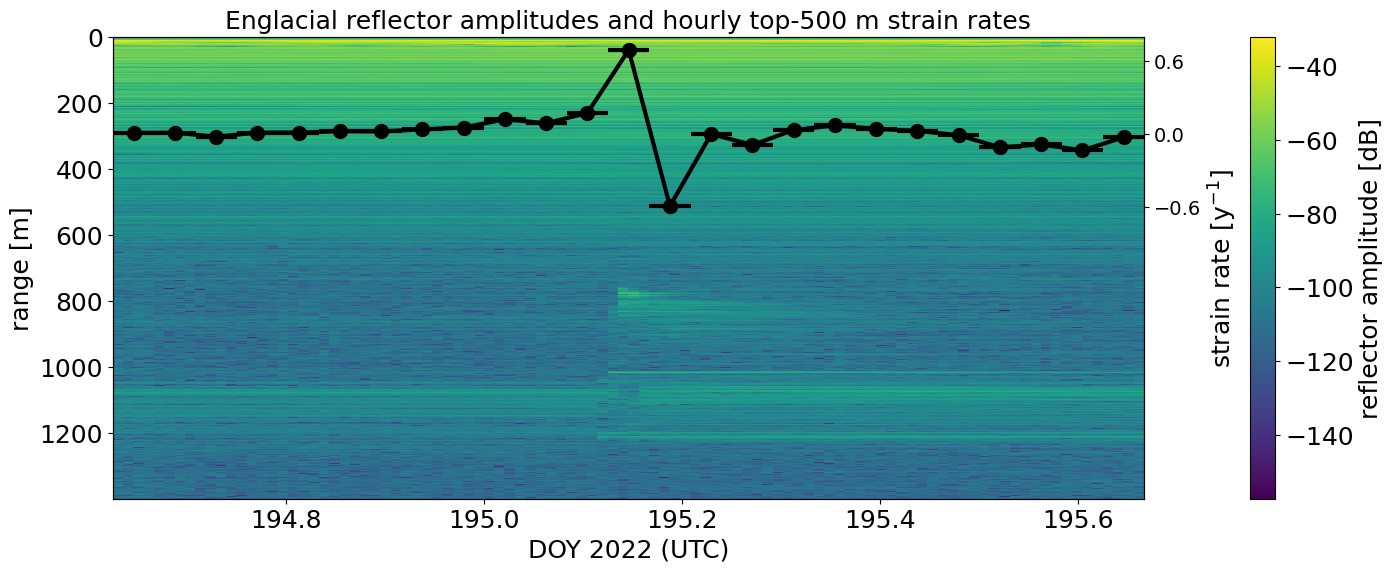

In [222]:
fig, [ax,cax] = plt.subplots(1,2, gridspec_kw=dict(width_ratios=[40,1]),figsize=(15,6))
da_crop = da_101_stacked.isel(time=range(4600,4700))
da_crop['doy_decimal'] = da_crop.time.dt.dayofyear + (da_crop.time.dt.hour / 24) + (da_crop.time.dt.minute / 1440) + (da_crop.time.dt.second / 86400)

im = xa.dB(da_crop).plot(ax=ax,x='doy_decimal',add_colorbar=False)
cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label='reflector amplitude [dB]', size=18)
b1= da_crop.isel(time=range(0,len(da_crop)-1))
b2 = da_crop.isel(time=range(1,len(da_crop)))
ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,80,80,None,0,0.95)

ax.invert_yaxis()
ax.set_title("Englacial reflector amplitudes",fontsize=18)
ax2 = ax.twinx()
ax2.set_ylim([-3,0.8])
#linestyles = ['-','--',':']
windows = ['1H','6H']
for i in range(1):
    disp_stack = ds_full.range_diff.resample(time=windows[i]).sum(dim='time')/convert_to_seconds(windows[i])*31536000
    err_stack = ds_full.err.resample(time=windows[i]).apply(error_prop)/convert_to_seconds(windows[i])*31536000
    strain_polyfit = disp_stack.where(disp_stack.profile_range <=500).polyfit('profile_range',1)
    to_plot = strain_polyfit.polyfit_coefficients.sel(degree=1)[:]
    to_plot['doy_decimal'] = to_plot.time.dt.dayofyear + ((to_plot.time.dt.hour+0.5) / 24) + (to_plot.time.dt.minute / 1440) + (to_plot.time.dt.second / 86400)
    ax2.errorbar(to_plot.doy_decimal.values,to_plot.values,None,0.5/24,color='k',marker='o',linewidth=3,markersize=10)
    #to_plot.plot(ax=ax2,x='doy_decimal',label=windows[i].replace('30T','0.5H'),linestyle=linestyles[i],color = 'k',linewidth=3)
ax2.set_ylabel('strain rate [y$^{-1}$]',fontsize=18)

ax.set_title("Englacial reflector amplitudes and hourly top-500 m strain rates",fontsize=18)
ax2.set_title("")
ax2.set_yticks([-0.6, 0, 0.6])
ax.set_xlabel('DOY 2022 (UTC)',fontsize=18)
ax.set_ylabel('range [m]',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('output_plot.png',transparent=True, dpi=300)

#plt.legend(fontsize=18)

Text(0.5, 0.01, 'vertical velocity [m y$^{-1}$]')

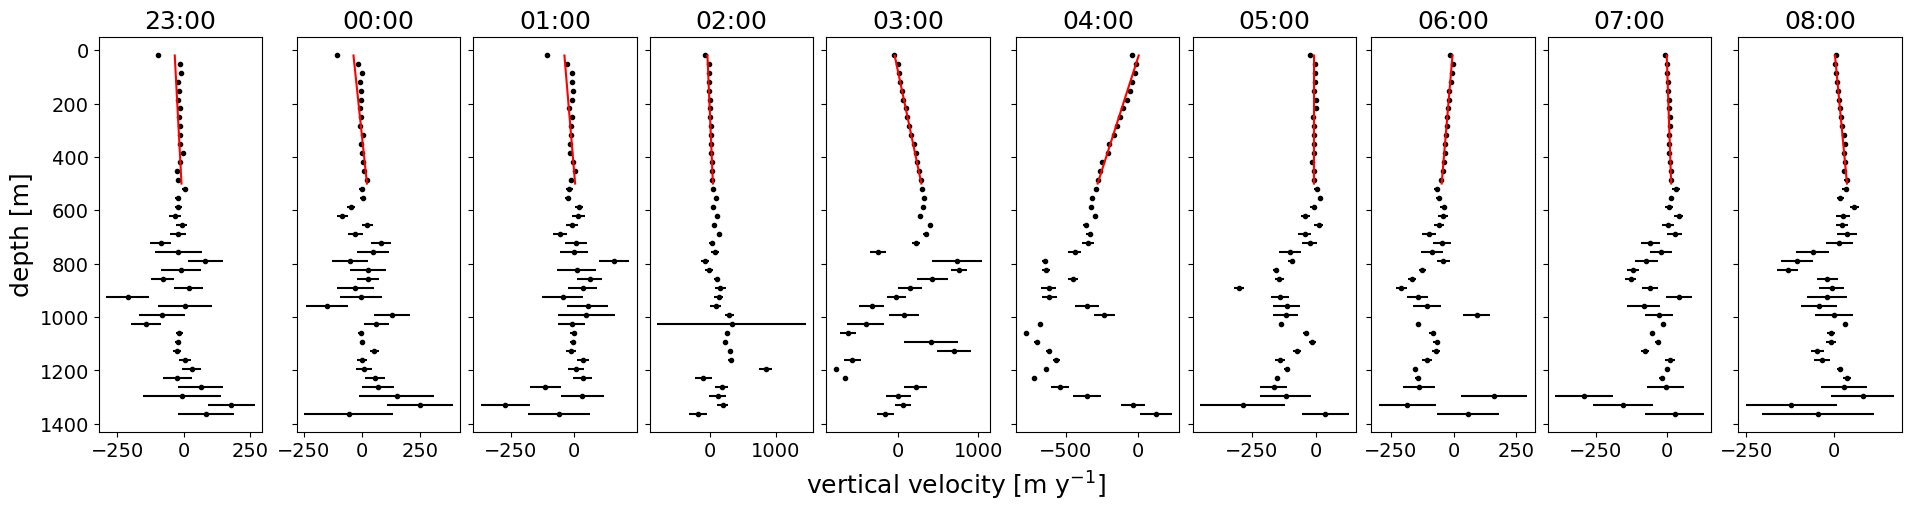

In [236]:
fig1, axs_1 = plt.subplots(ncols=10,figsize=(19,5),sharey=True,layout='constrained')
#fig1.suptitle('Strain fitting (\u03B5\u0307 in 10$^{-3}$ yr$^{-1}$)',fontsize=18)
disp_stack['doy_decimal'] = disp_stack.time.dt.dayofyear + ((disp_stack.time.dt.hour) / 24) + (disp_stack.time.dt.minute / 1440) + (disp_stack.time.dt.second / 86400)

plt_count = 0
for i in np.arange(8,18,1):
    axs_1[plt_count].errorbar(disp_stack.isel(time = i) ,disp_stack.profile_range,yerr=None,xerr=err_stack.isel(time = i),linestyle='',marker='.',color='k',zorder=1)
    fit = strain_polyfit.polyfit_coefficients.sel(degree=1).isel(time=i).values*np.linspace(20,500)+strain_polyfit.polyfit_coefficients.sel(degree=0).isel(time=i).values

    axs_1[plt_count].plot(fit,np.linspace(20,500),color='r',zorder=2)
    unit = ''#'x10$^{-3}$ yr$^{-1}$'
    #axs_1[plt_count].text(-0.2,300, f"\u03B5\u0307= {strain_polyfit.polyfit_coefficients.sel(degree=1).isel(time=i).values*1000:.2g}"+unit,color = 'r',fontsize=14)
    axs_1[plt_count].set_title(f'{str(disp_stack.time.isel(time = i).values)[11:16]}',fontsize=18)
    #axs_1[plt_count].set_xlim([-3,2])
    #axs_1[plt_count].set_ylim([20,500])
    axs_1[plt_count].tick_params(axis='both', which='major', labelsize=14)
    plt_count += 1
    if plt_count == 10:
        break

axs_1[0].invert_yaxis()

axs_1[0].set_ylabel('depth [m]',fontsize=18)
fig1.supxlabel('vertical velocity [m y$^{-1}$]',fontsize=18)

In [191]:
to_plot.values

array([ 0.00899213,  0.010539  , -0.02226349,  0.01162856,  0.01208698,
        0.02314991,  0.02079593,  0.03804078,  0.05300261,  0.12090158,
        0.08805641,  0.17296673,  0.69030869, -0.59318031, -0.00109694,
       -0.08991303,  0.03247131,  0.070928  ,  0.04125595,  0.02605039,
       -0.01031107, -0.10946396, -0.08633291, -0.13508163])

INFO     17:17:10 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [900. 904. 895. ... 901. 900. 900.]s


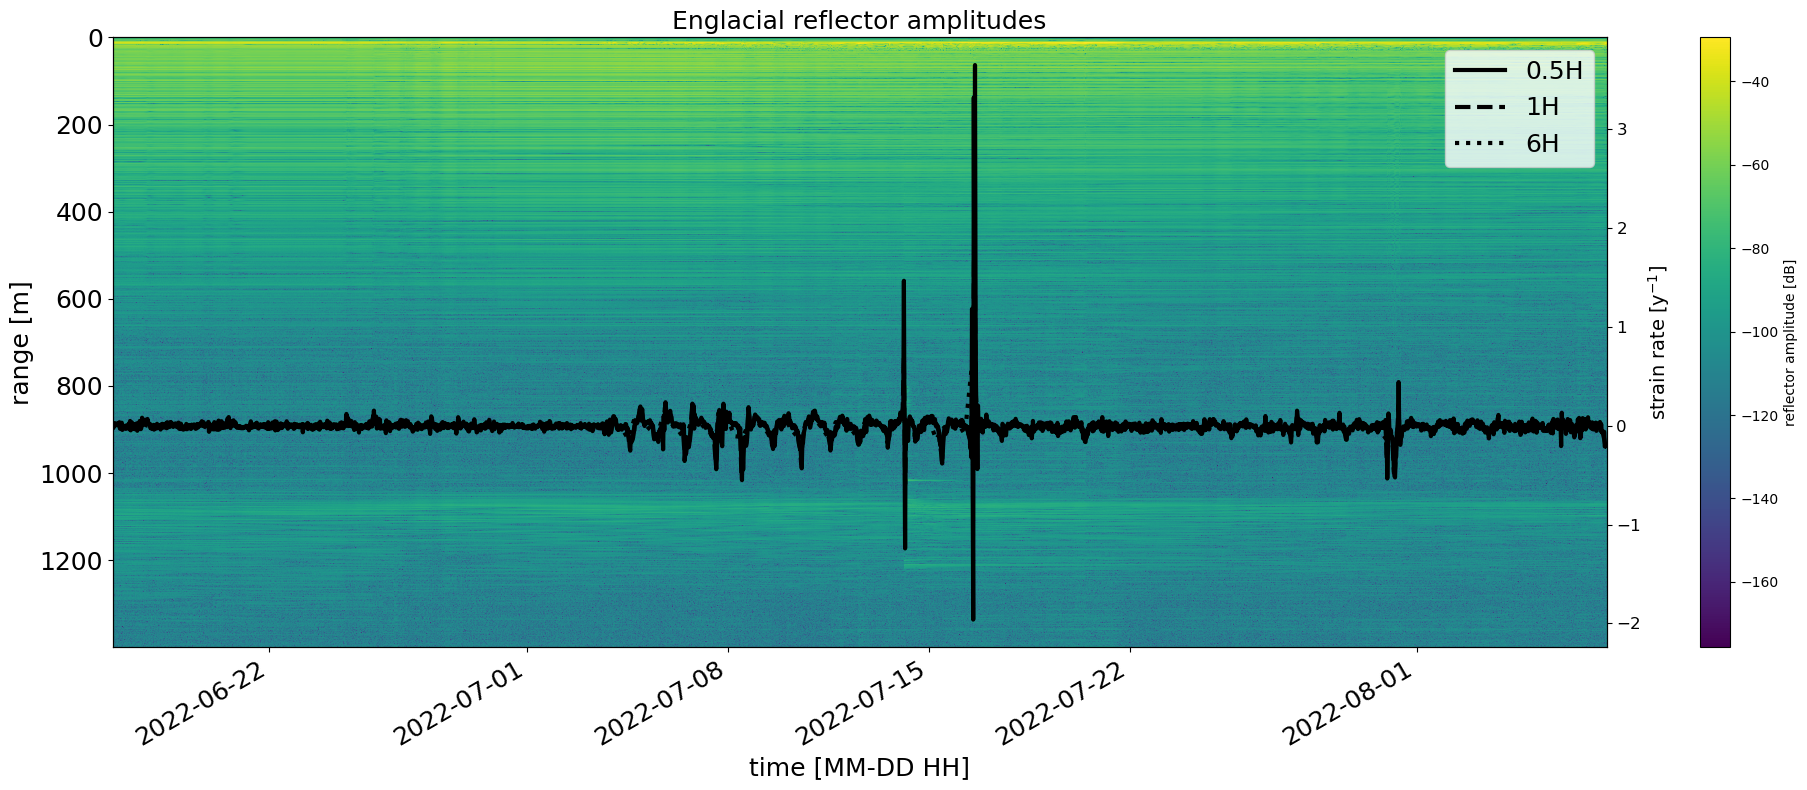

In [49]:
fig, ax = plt.subplots(figsize=(20,8),layout='tight')
da_crop = da_101_stacked.isel(time=range(2000,7000))

xa.dB(da_crop).plot(ax=ax,x='time',cbar_kwargs={'label':'reflector amplitude [dB]'})
b1= da_crop.isel(time=range(0,len(da_crop)-1))
b2 = da_crop.isel(time=range(1,len(da_crop)))
ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,80,80,None,0,0.95)

ax.invert_yaxis()
ax.set_title("Englacial reflector amplitudes",fontsize=18)
ax2 = ax.twinx()
#ax2.set_ylim([-0.8,0.8])
linestyles = ['-','--',':']
windows = ['30T','1H','6H']
for i in range(0,3):
    disp_stack = ds_full.range_diff.resample(time=windows[i]).sum(dim='time')/convert_to_seconds(windows[i])*31536000
    err_stack = ds_full.err.resample(time=windows[i]).apply(error_prop)/convert_to_seconds(windows[i])*31536000
    strain_polyfit = disp_stack.where(disp_stack.profile_range <=500).polyfit('profile_range',1)

    strain_polyfit.polyfit_coefficients.sel(degree=1).plot(ax=ax2,label=windows[i].replace('30T','0.5H'),linestyle=linestyles[i],color = 'k',linewidth=3)
ax2.set_ylabel('strain rate [y$^{-1}$]',fontsize=14)

ax.set_title("Englacial reflector amplitudes",fontsize=18)
ax2.set_title("")

ax.set_xlabel('time [MM-DD HH]',fontsize=18)
ax.set_ylabel('range [m]',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize=18)

Text(0, 0.5, 'upwards displacement [m]')

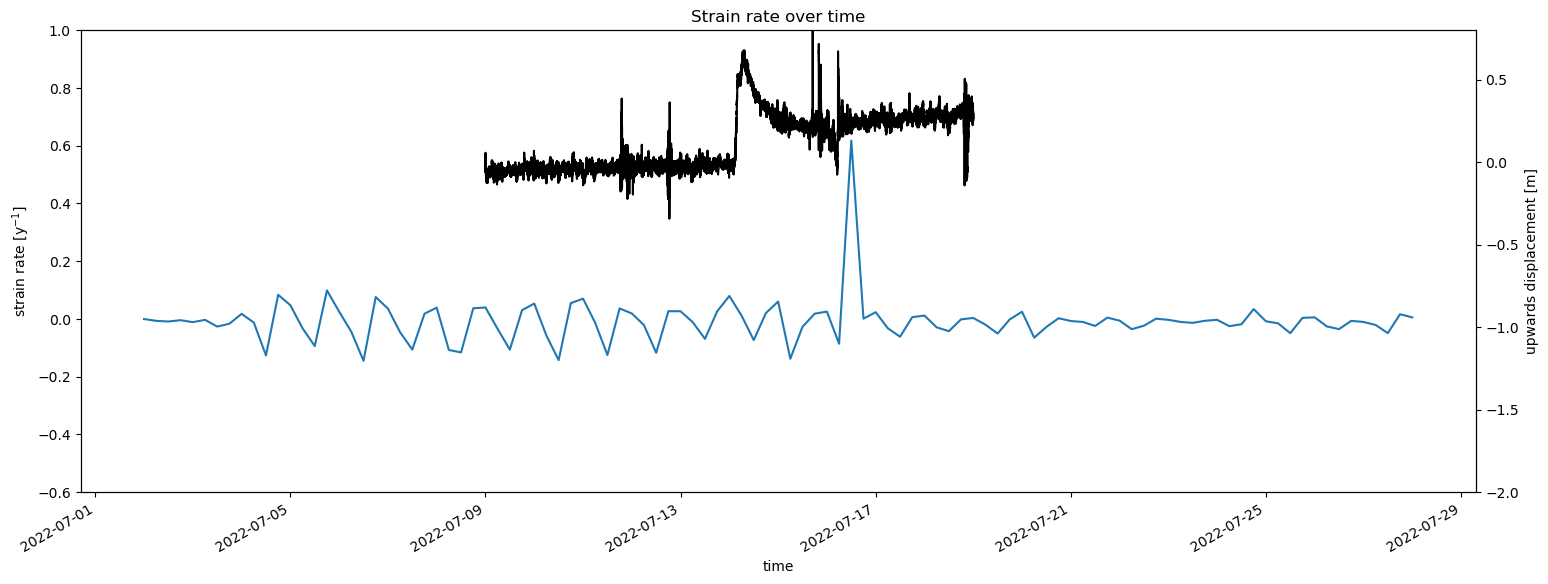

In [41]:
fig, ax = plt.subplots(figsize=(18,6))
strain_polyfit.polyfit_coefficients.sel(degree=1).plot(ax=ax)
ax.set_title('Strain rate over time')
ax.set_ylabel('strain rate [y$^{-1}$]')
ax.set_ylim([-0.6, 1])
ax2 = ax.twinx()
ax2.set_ylim([-2,0.8])
data.Up.plot(ax=ax2,color='k',label='upwards displacement')
ax2.set_ylabel('upwards displacement [m]')

In [50]:
# trying analysis with 103 data
da_103_stacked  = ds_103_s.profile_stacked.isel(attenuator_setting_pair=2,time=range(20000,40000)).compute()

INFO     17:20:30 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [175. 174. 173. ... 266. 264. 267.]s


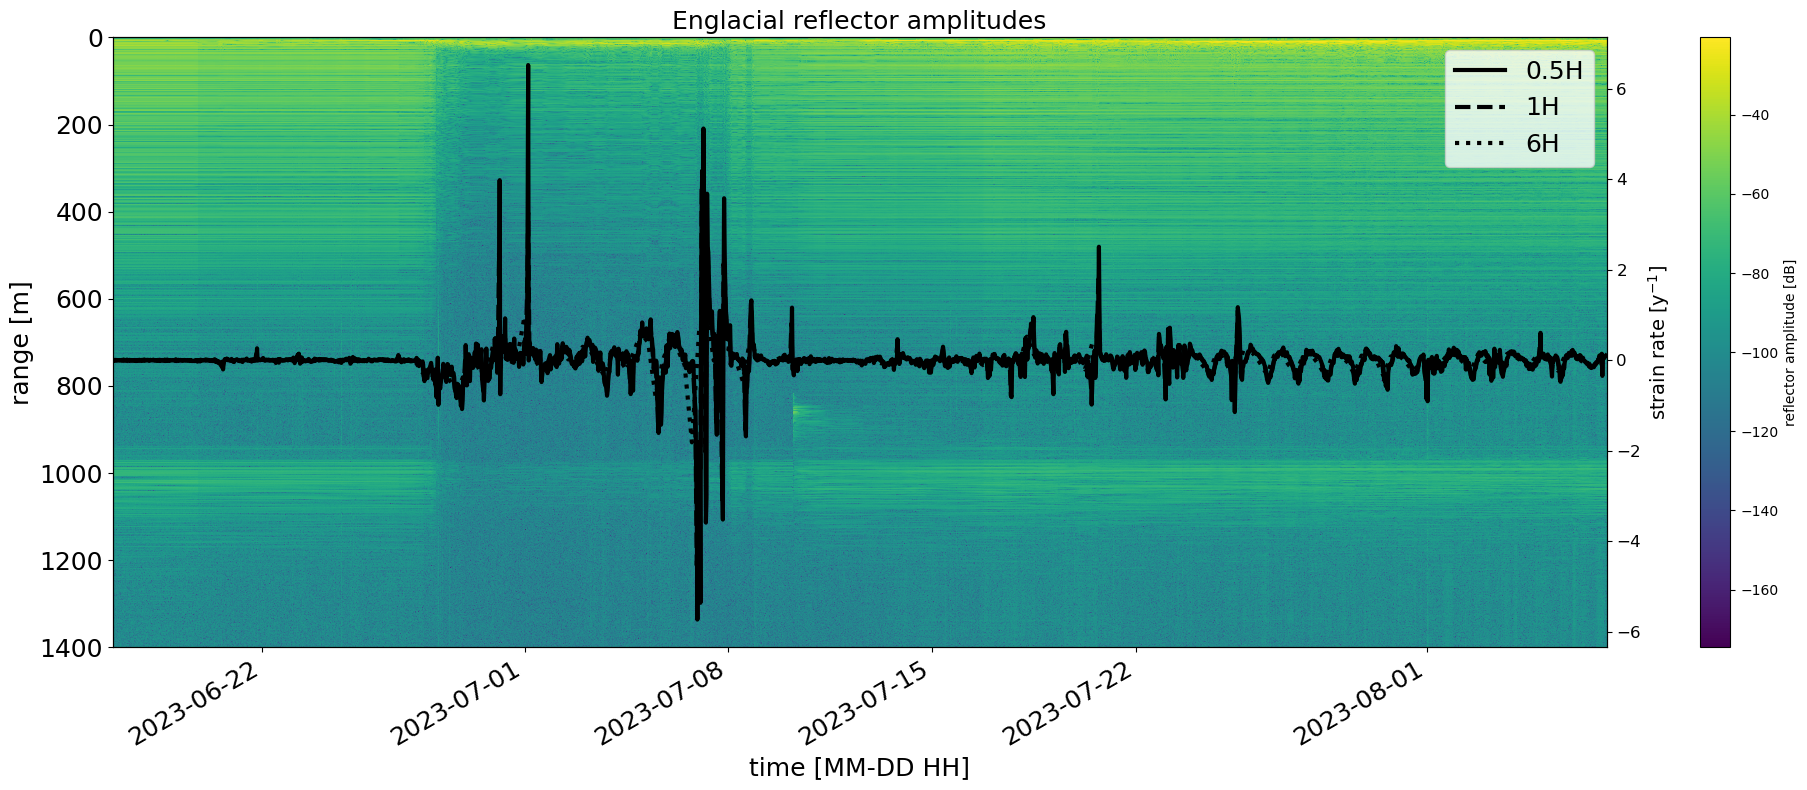

In [51]:
fig, ax = plt.subplots(figsize=(20,8),layout='tight')
da_crop = da_103_stacked#.isel(time=range(3500,6000))

xa.dB(da_crop).plot(ax=ax,x='time',cbar_kwargs={'label':'reflector amplitude [dB]'})
b1= da_crop.isel(time=range(0,len(da_crop)-1))
b2 = da_crop.isel(time=range(1,len(da_crop)))
ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,80,80,None,0,0.95)

ax.invert_yaxis()
ax.set_title("Englacial reflector amplitudes",fontsize=18)
ax2 = ax.twinx()
#ax2.set_ylim([-0.8,0.8])
linestyles = ['-','--',':']
windows = ['30T','1H','6H']
for i in range(0,3):
    disp_stack = ds_full.range_diff.resample(time=windows[i]).sum(dim='time')/convert_to_seconds(windows[i])*31536000
    err_stack = ds_full.err.resample(time=windows[i]).apply(error_prop)/convert_to_seconds(windows[i])*31536000
    strain_polyfit = disp_stack.where(disp_stack.profile_range <=500).polyfit('profile_range',1)

    strain_polyfit.polyfit_coefficients.sel(degree=1).plot(ax=ax2,label=windows[i].replace('30T','0.5H'),linestyle=linestyles[i],color = 'k',linewidth=3)
ax2.set_ylabel('strain rate [y$^{-1}$]',fontsize=14)

ax.set_title("Englacial reflector amplitudes",fontsize=18)
ax2.set_title("")

ax.set_xlabel('time [MM-DD HH]',fontsize=18)
ax.set_ylabel('range [m]',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize=18)

INFO     15:24:08 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [899. 901. 900. 899. 901. 900. 900. 900. 900. 900. 902. 899. 899. 901.
 929. 868. 900. 900. 901. 902. 899. 900. 900. 930. 870. 900. 900. 899.
 901. 900. 900. 900. 907. 895. 901. 902. 897. 904. 900. 903. 901. 901.
 919. 869. 900. 901. 899. 901. 899.]s
INFO     15:24:08 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [899. 901. 900. 899. 901. 900. 900. 900. 900. 900. 902. 899. 899. 901.
 929. 868. 900. 900. 901. 902. 899. 900. 900. 930. 870. 900. 900. 899.
 901. 900. 900. 900. 907. 895. 901. 902. 897. 904. 900. 903. 901. 901.
 919. 869. 900. 901. 899. 901. 899.]s
INFO     15:24:08 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [899. 901. 900. 899. 901. 900. 900. 900. 900. 900. 902. 899. 899. 901.
 929. 868. 900. 900. 901. 902. 899. 900. 900. 930. 870. 900. 900. 899.
 901. 900. 900. 900. 907. 895. 901. 902. 897. 904. 900. 903. 901. 90

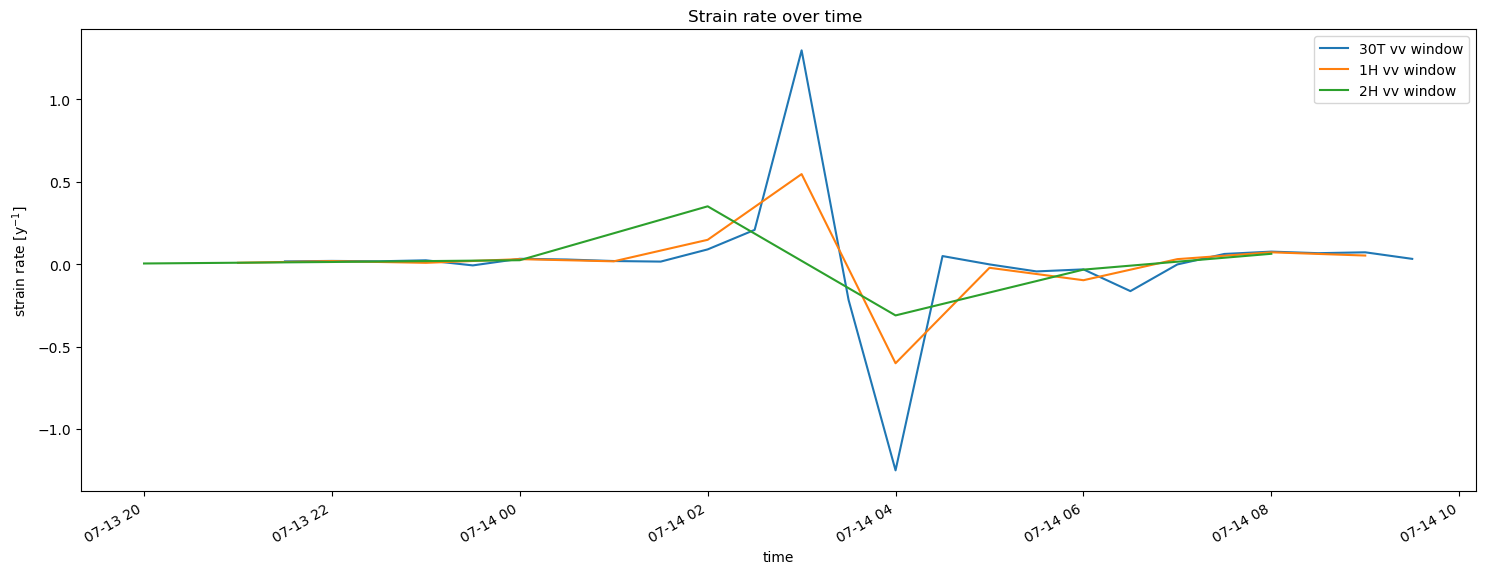

In [106]:
vd_sum = '1H'
fig, ax = plt.subplots(figsize=(18,6))

for i in ['30T','1H','2H']:
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,80,80,None,0,0.95)
    disp_stack = ds_full.range_diff.resample(time=i).sum(dim='time')/convert_to_seconds(i)*31536000
    err_stack = ds_full.err.resample(time=i).apply(error_prop)/convert_to_seconds(i)*31536000
    strain_polyfit = disp_stack.polyfit('profile_range',1,w=1/err_stack.mean(dim='time'))
    strain_polyfit.polyfit_coefficients.sel(degree=1).plot(ax=ax,label=f'{i} vv window')
    ax.set_title(f'Strain rate over time ')
    ax.set_ylabel('strain rate [y$^{-1}$]')

plt.legend()

INFO     15:24:12 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [899. 901. 900. 899. 901. 900. 900. 900. 900. 900. 902. 899. 899. 901.
 929. 868. 900. 900. 901. 902. 899. 900. 900. 930. 870. 900. 900. 899.
 901. 900. 900. 900. 907. 895. 901. 902. 897. 904. 900. 903. 901. 901.
 919. 869. 900. 901. 899. 901. 899.]s


Text(0.5, 0.01, 'vertical velocity [m y$^{-1}$]')

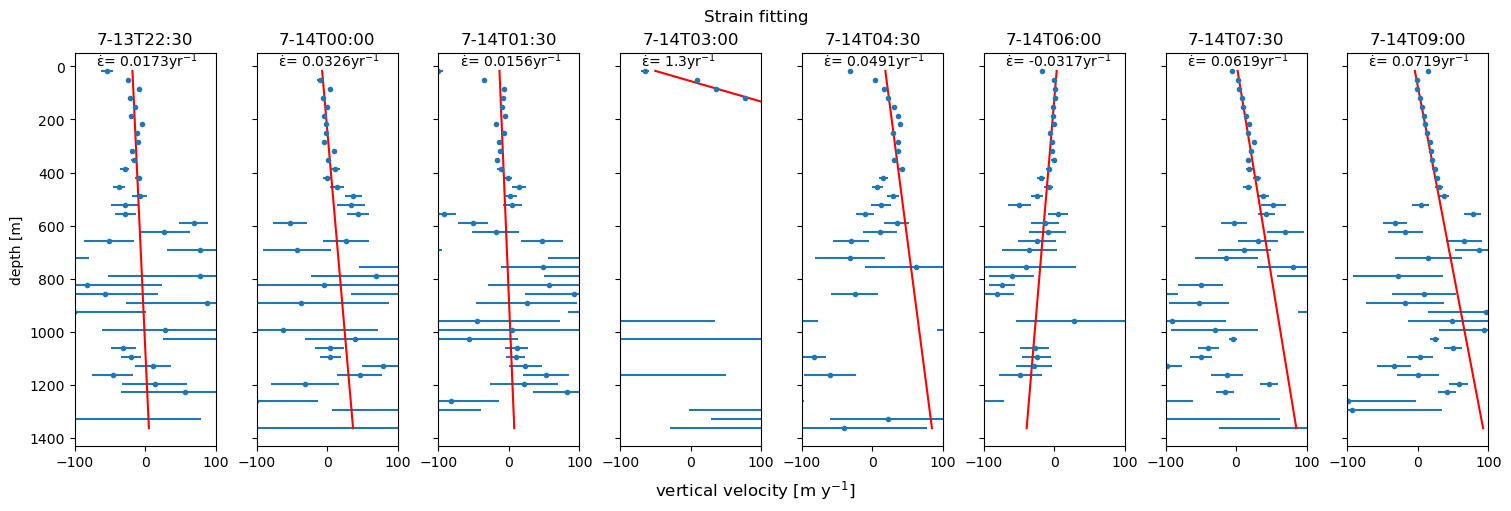

In [107]:
fig1, axs_1 = plt.subplots(ncols=8,figsize=(15,5),sharey=True,layout='constrained')
fig1.suptitle('Strain fitting')
# Plotting displacement for individual layers 
for j in ['30T']:
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,80,80,None,0,0.95)
    disp_stack = ds_full.range_diff.resample(time=j).sum(dim='time')/convert_to_seconds(j)*31536000
    err_stack = ds_full.err.resample(time=j).apply(error_prop)/convert_to_seconds(j)*31536000
    strain_polyfit = disp_stack.polyfit('profile_range',1,w=1/err_stack.mean(dim='time'))
    plt_count = 0
    for i in np.arange(math.ceil(0.05*len(disp_stack.time)),len(disp_stack.time),len(disp_stack.time)//8):
        axs_1[plt_count].errorbar(disp_stack.isel(time = i) ,disp_stack.profile_range,yerr=None,xerr=err_stack.isel(time = i),linestyle='',marker='.')
        fit = strain_polyfit.polyfit_coefficients.sel(degree=1).isel(time=i)*disp_stack.profile_range+strain_polyfit.polyfit_coefficients.sel(degree=0).isel(time=i)

        axs_1[plt_count].plot(fit,disp_stack.profile_range,color='r')
        unit = 'yr$^{-1}$'
        axs_1[plt_count].text(-70,0, f"\u03B5\u0307= {strain_polyfit.polyfit_coefficients.sel(degree=1).isel(time=i).values:.3g}"+unit)
        axs_1[plt_count].set_title(f'{disp_stack.time.isel(time = i).values.astype(str)[6:16]}')
        axs_1[plt_count].set_xlim([-100,100])
        plt_count += 1
        if plt_count == 8:
            break

axs_1[0].invert_yaxis()

axs_1[0].set_ylabel('depth [m]')
fig1.supxlabel('vertical velocity [m y$^{-1}$]')

In [121]:
vd_sum = '1H'

ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,80,80,None,0,0.95)
disp_stack = ds_full.range_diff.resample(time=vd_sum).sum(dim='time')/convert_to_seconds(vd_sum)*31536000
err_stack = ds_full.err.resample(time=vd_sum).apply(error_prop)/convert_to_seconds(vd_sum)*31536000
strain_polyfit = disp_stack.polyfit('profile_range',1,w=1/err_stack.mean(dim='time'))



INFO     15:39:48 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [899. 901. 900. 899. 901. 900. 900. 900. 900. 900. 902. 899. 899. 901.
 929. 868. 900. 900. 901. 902. 899. 900. 900. 930. 870. 900. 900. 899.
 901. 900. 900. 900. 907. 895. 901. 902. 897. 904. 900. 903. 901. 901.
 919. 869. 900. 901. 899. 901. 899.]s


Error in callback <function _draw_all_if_interactive at 0x7f06c25cb250> (for post_execute):


ValueError: not enough values to unpack (expected 4, got 0)

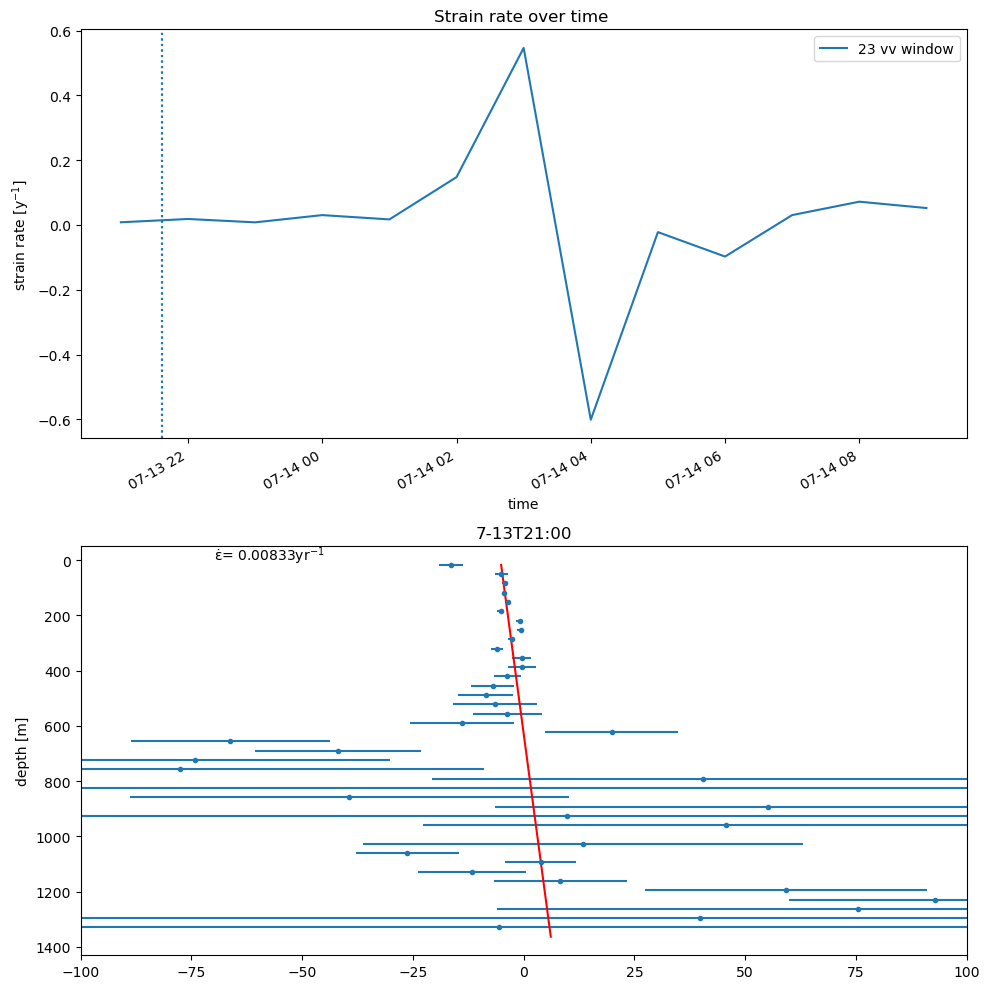

In [140]:
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='jshtml')

fig, ax = plt.subplots(nrows=2,figsize=(10,10),layout='tight')
strain_polyfit.polyfit_coefficients.sel(degree=1).plot(ax=ax[0],label=f'{i} vv window')
ax[0].set_title(f'Strain rate over time ')
ax[0].set_ylabel('strain rate [y$^{-1}$]')
to_plot = ax[0].axvline(ds_full.time.values[0],linestyle=':')
ax[0].legend()

update = ax[1].errorbar(disp_stack.isel(time = 0) ,disp_stack.profile_range,yerr=None,xerr=err_stack.isel(time = 0),linestyle='',marker='.')
fit = strain_polyfit.polyfit_coefficients.sel(degree=1).isel(time=0)*disp_stack.profile_range+strain_polyfit.polyfit_coefficients.sel(degree=0).isel(time=0)

update_1 = ax[1].plot(fit,disp_stack.profile_range,color='r')
unit = 'yr$^{-1}$'
update_2 = ax[1].text(-70,0, f"\u03B5\u0307= {strain_polyfit.polyfit_coefficients.sel(degree=1).isel(time=0).values:.3g}"+unit)
ax[1].set_title(f'{disp_stack.time.isel(time = 0).values.astype(str)[6:16]}')
ax[1].set_xlim([-100,100])
ax[1].invert_yaxis()
ax[1].set_ylabel('depth [m]')

def animate(i):

    to_plot = ax[0].axvline(ds_full.time.values[i],linestyle=':')
    update.set_array(disp_stack.isel(time = i) ,disp_stack.profile_range,yerr=None,xerr=err_stack.isel(time = i))
    ax[1].set_title(f'{disp_stack.time.isel(time = i).values.astype(str)[6:16]}')
anim = animation.FuncAnimation(fig, animate, frames=ds_full.time.size//10, repeat=True)


In [136]:
HTML(anim.to_jshtml())
